In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.chdir('..')

In [3]:
import pickle
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from utils import laion_utils as laionu

# Settings

## Path

In [4]:
# LAIONets
laion_path = 'laion400m'
laion_until_part = 31

prefixes = [
    f'subset_sm_filt(mm_{0.72}_{0.3037})',
    f'subset_sm_filt(mm_{0.76}_{0.2959})',
    f'subset_sm_filt(mm_{0.79}_{0.2828})',
    f'subset_sm_filt(mm_{0.81}_{0.2579})',
]

tags = ['D', 'C', 'B', 'A']

postfixes = [
    '',
    '(vit-base-patch16-224)',
    '(beit-base-patch16-224)',
    '(convnext-base-224-22k-1k)',
]

enc_tags = ['CLIP', 'ViT', 'BEiT', 'ConvNeXT']

# ILSVRC
ival_prefix = 'ILSVRC2012_val'

# Labels (maps)
labels_path = os.path.join(laion_path, 'processed', 'ilsvrc_labels')
prefix_to_labels_filter = lambda p: f'wnid2laionindices({p}).pkl'

# Intra-class similarities
img_img_sims_path = os.path.join('laion400m', 'processed', 'clip_image_similarities')
prefix_postfix_wnid_to_img_img_sim_file_name = lambda pre, pos, w: pre + f'_img_img_sims({w}){pos}.pkl'

# Load

## Load maps

In [5]:
prefix2wnid2laionindices = {}
for prefix in tqdm(prefixes):
    # Load the map
    with open(os.path.join(labels_path, prefix_to_labels_filter(prefix)), 'rb') as f:
        wnid2laionindices = pickle.load(f)

    # Drop empty indices
    wnid2laionindices = {wnid: indices for wnid, indices in wnid2laionindices.items() if len(indices) > 0}
    
    prefix2wnid2laionindices[prefix] = wnid2laionindices

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.74it/s]


## Load intra-class similarities

In [6]:
def vec(x):
    msk = np.tril(np.eye(len(x)) < 0.5)
    return x[msk]

In [7]:
prefix2postfix2wnid2sims = {pre: {pos: {} for pos in postfixes} for pre in prefixes}

for pre in prefixes:
    for pos in postfixes:
        for wnid in prefix2wnid2laionindices[pre]:
            ppw_sim_path = os.path.join(img_img_sims_path, prefix_postfix_wnid_to_img_img_sim_file_name(pre, pos, wnid))

            if not os.path.exists(ppw_sim_path):
                continue

            with open(ppw_sim_path, 'rb') as f:
                ppw_sim_dict = pickle.load(f)

            ppw_sim = ppw_sim_dict['similarities']

            prefix2postfix2wnid2sims[pre][pos][wnid] = vec(ppw_sim)

        print(pre, pos, len(prefix2postfix2wnid2sims[pre][pos]))

subset_sm_filt(mm_0.72_0.3037)  904
subset_sm_filt(mm_0.72_0.3037) (vit-base-patch16-224) 904
subset_sm_filt(mm_0.72_0.3037) (beit-base-patch16-224) 904
subset_sm_filt(mm_0.72_0.3037) (convnext-base-224-22k-1k) 904
subset_sm_filt(mm_0.76_0.2959)  910
subset_sm_filt(mm_0.76_0.2959) (vit-base-patch16-224) 910
subset_sm_filt(mm_0.76_0.2959) (beit-base-patch16-224) 910
subset_sm_filt(mm_0.76_0.2959) (convnext-base-224-22k-1k) 910
subset_sm_filt(mm_0.79_0.2828)  905
subset_sm_filt(mm_0.79_0.2828) (vit-base-patch16-224) 905
subset_sm_filt(mm_0.79_0.2828) (beit-base-patch16-224) 905
subset_sm_filt(mm_0.79_0.2828) (convnext-base-224-22k-1k) 905
subset_sm_filt(mm_0.81_0.2579)  900
subset_sm_filt(mm_0.81_0.2579) (vit-base-patch16-224) 900
subset_sm_filt(mm_0.81_0.2579) (beit-base-patch16-224) 900
subset_sm_filt(mm_0.81_0.2579) (convnext-base-224-22k-1k) 900


In [8]:
ivalpostfix2wnid2sims = {pos: {} for pos in postfixes}

for pos in postfixes:
    for wnid in prefix2wnid2laionindices[prefixes[0]]:
        ival_pw_sim_path = os.path.join(img_img_sims_path, prefix_postfix_wnid_to_img_img_sim_file_name(ival_prefix, pos, wnid))

        if not os.path.exists(ival_pw_sim_path):
            continue

        with open(ival_pw_sim_path, 'rb') as f:
            ival_pw_sim_dict = pickle.load(f)

        ival_pw_sim = ival_pw_sim_dict['similarities']

        ivalpostfix2wnid2sims[pos][wnid] = vec(ival_pw_sim)

    print(pos, len(ivalpostfix2wnid2sims[pos]))

 922
(vit-base-patch16-224) 922
(beit-base-patch16-224) 922
(convnext-base-224-22k-1k) 922


# Process

## Find common WNIDs

In [9]:
common_wnids = set(prefix2postfix2wnid2sims[prefixes[0]][postfixes[0]].keys())

for pre in prefixes:
    for pos in postfixes:
        common_wnids.intersection_update(prefix2postfix2wnid2sims[pre][pos].keys())
    
print(len(common_wnids))

887


## Resample similarities for each common WNID

In [10]:
prefix2postfix2sims = {pre: {pos: [] for pos in postfixes} for pre in prefixes}

for pre in tqdm(prefixes):
    for pos in postfixes:
        for wnid in common_wnids:
            sims = prefix2postfix2wnid2sims[pre][pos][wnid]

            n_sample = np.min([len(sims), 100])

            prefix2postfix2sims[pre][pos].extend(np.random.choice(sims, size=(n_sample,), replace=True))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


In [11]:
ivalpostfix2sims = {pos: [] for pos in postfixes}

for pos in postfixes:
    for wnid in common_wnids:
        sims = ivalpostfix2wnid2sims[pos][wnid]

        n_sample = np.min([len(sims), 100])

        ivalpostfix2sims[pos].extend(np.random.choice(sims, size=(n_sample,), replace=True))

# Plot distributions

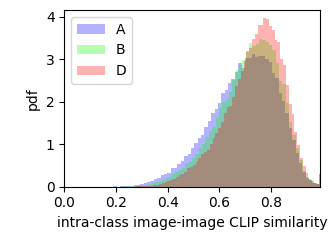

In [12]:
plt.figure(figsize=(3.4, 2.5))

chosen_postfix = postfixes[0]
chosen_prefixes = np.array(prefixes)[[0, 2, 3]].tolist()
chosen_tags = np.array(tags)[[0, 2, 3]].tolist()
assert len(chosen_prefixes) == 3

cl = lambda i_p: [(i_p == 2)*1, (i_p == 1)*1, (i_p == 0)*1]

for i_p, pre in enumerate(chosen_prefixes[::-1]):
    _ = plt.hist(prefix2postfix2sims[pre][chosen_postfix], bins=70, color=cl(i_p), alpha=0.3, density=True)

plt.legend(chosen_tags[::-1])

plt.xlabel('intra-class image-image CLIP similarity')
plt.ylabel('\npdf')

plt.xlim([0, 0.99])

plt.tight_layout()

plt.savefig(os.path.join('figs', f'subset_sm_filt_mms_img_img_sims_resampled.pdf'), bbox_inches='tight')

# Plot avg. similarities

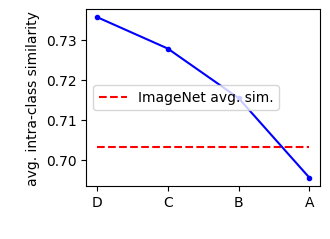

In [13]:
plt.figure(figsize=(3.4, 2.5))

avg_sims = [np.mean(prefix2postfix2sims[pre][chosen_postfix]) for pre in prefixes]

ival_avg_sim = np.mean(ivalpostfix2sims[chosen_postfix])

plt.plot([ival_avg_sim]*len(prefixes), 'r--')

plt.legend(['ImageNet avg. sim.'], loc='center left')

plt.plot(avg_sims, 'b', marker='.')

plt.xticks(ticks=range(len(prefixes)), labels=tags)

plt.xlabel(' ')
plt.ylabel('\navg. intra-class similarity')

plt.tight_layout()

plt.savefig(os.path.join('figs', f'subset_sm_filt_mms_img_img_sims_avg.pdf'), bbox_inches='tight')

# Plot prop. of classes for all encoders

In [14]:
prefix2postfix2cntlower = {pre: {pos: 0 for pos in postfixes} for pre in prefixes}
prefix2postfix2cnthigher = {pre: {pos: 0 for pos in postfixes} for pre in prefixes}

for pre in prefixes:
    for pos in postfixes:
        for wnid in common_wnids:
            if np.mean(prefix2postfix2wnid2sims[pre][pos][wnid]) <= np.mean(ivalpostfix2wnid2sims[pos][wnid]):
                prefix2postfix2cntlower[pre][pos] += 1
            else:
                prefix2postfix2cnthigher[pre][pos] += 1 

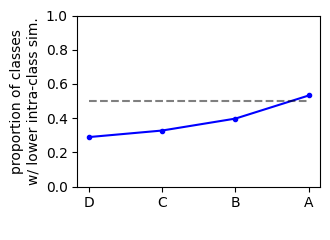

In [15]:
plt.figure(figsize=(3.4, 2.5))

prop_lowers = []
for pre in prefixes:
    l = prefix2postfix2cntlower[pre][chosen_postfix]
    h = prefix2postfix2cnthigher[pre][chosen_postfix]
    prop_lowers.append(l / (l + h))

plt.plot(prop_lowers, 'b', marker='.')

plt.xlabel(' ')
plt.ylabel('proportion of classes\nw/ lower intra-class sim.')

plt.plot([0.5]*len(prefixes), 'k--', alpha=0.5)

plt.ylim([0, 1])

plt.xticks(ticks=range(len(prefixes)), labels=tags)

plt.tight_layout()

plt.savefig(os.path.join('figs', f'laionets_prop_lower_sim.pdf'), bbox_inches='tight')

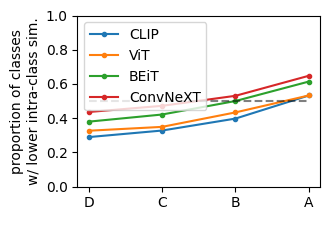

In [16]:
plt.figure(figsize=(3.4, 2.5))

for pos in postfixes:
    prop_lowers = []
    for pre in prefixes:
        l = prefix2postfix2cntlower[pre][pos]
        h = prefix2postfix2cnthigher[pre][pos]
        prop_lowers.append(l / (l + h))
        
    plt.plot(prop_lowers, marker='.')
    
plt.ylabel('proportion of classes\nw/ lower intra-class sim.')
plt.legend(enc_tags)

plt.plot([0.5]*len(prefixes), 'k--', alpha=0.5)

plt.xlabel(' ')
plt.ylim([0, 1])

plt.xticks(ticks=range(len(prefixes)), labels=tags)

plt.tight_layout()

plt.savefig(os.path.join('figs', f'laionets_all_enc_prop_lower_sim.pdf'), bbox_inches='tight')